## Importing libraries

In [4]:
import numpy as np
from matplotlib import image
import matplotlib.pyplot as plt
import cv2 
from skimage.feature import peak_local_max
from scipy import signal

## Reading images

In [2]:
img1 = cv2.imread('im01.jpg')
img2 = cv2.imread('im02.jpg')

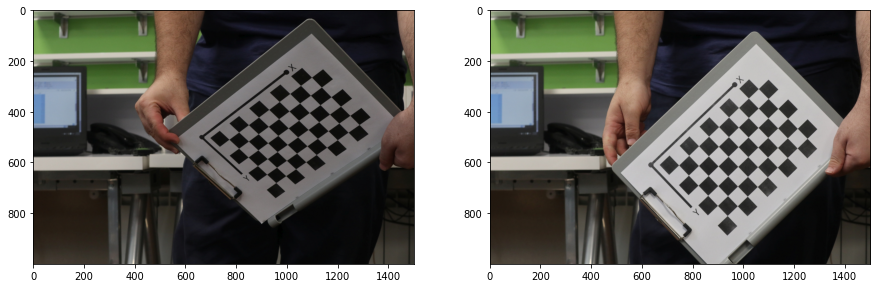

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
axs[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB));

## Edge detection

We use Canny edge detection

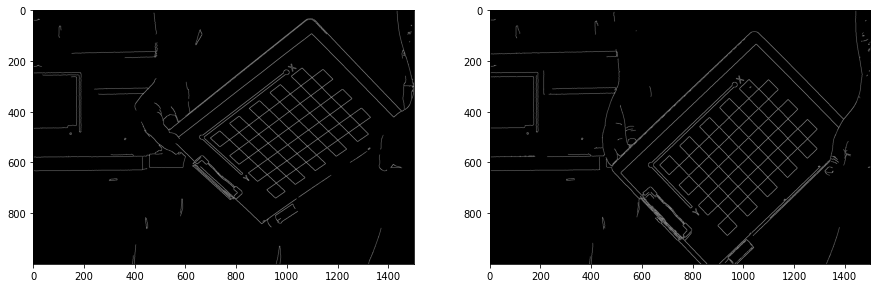

In [19]:
edges1, edges2 = [cv2.Canny(im, 100, 200) for im in [img1, img2]]

fig, axs = plt.subplots(1, 2, figsize=(15, 10))

axs[0].imshow(edges1, cmap='gray')
axs[1].imshow(edges2, cmap='gray');

## Hough Transform

To discretize $\theta$ and $\rho$ We split

- $\theta$ ($[-\pi/2 , \pi/2]$) to $500$ parts **(Note that if we used $[-\pi , \pi]$, we would have $2$ different representation for each line)**
- $\rho$ ($[-D , D]$) to $500$ parts (where $D$ denotes the diameter of the image)

In [20]:
theta_shift = np.pi/2
theta_cnt = 500
ro_shift = np.sqrt((edges1.shape[0]//2)**2 + (edges1.shape[1]//2)**2)
ro_cnt = 500

Using the below formula we calculate the accumulator

$\rho = y \times \cos(\theta) + x \times \sin(\theta)$

In [22]:
def calculate_acc(img):
    A = np.zeros((theta_cnt, ro_cnt))
    x_arr, y_arr = np.where(img > 0) # mask for pixels of edges
    # Normalizing
    x_arr = x_arr - edges1.shape[0]//2
    y_arr = y_arr - edges1.shape[1]//2
    for theta_idx in range(theta_cnt):
        theta = (theta_idx/theta_cnt) * (2*theta_shift) - theta_shift
        ro = y_arr*np.cos(theta) + x_arr*np.sin(theta)
        ro = np.round(((ro + ro_shift)/(2*ro_shift)) * ro_cnt)
        ro_idx, ro_idx_count = np.unique(ro, return_counts=True)
        A[theta_idx, ro_idx.astype(np.int16)] += ro_idx_count
    
    return A

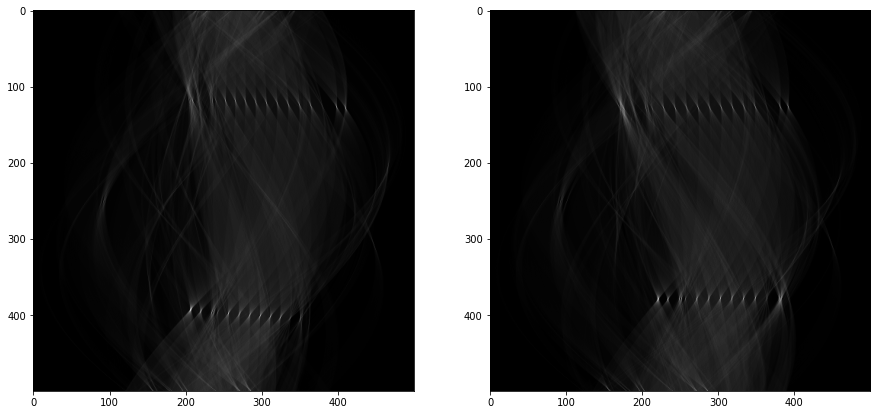

In [23]:
A1, A2 = [calculate_acc(im) for im in [edges1, edges2]]

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(A1, cmap='gray')
axs[1].imshow(A2, cmap='gray');

get local maximas using `peak_local_max`

In [24]:
theta_ro_idx_arr1 = peak_local_max(A1, min_distance=12, threshold_rel=0.4)
theta_ro_idx_arr2 = peak_local_max(A2, min_distance=12, threshold_rel=0.4)

This function, as the name implies, generate two points from the given line. 

Note: the line is determined by $\theta$ and $\rho$

In [25]:
def generate_two_points_from_line(theta_idx, ro_idx):
    y_func = lambda ro, theta, x: (ro - x*np.cos(theta))/np.sin(theta)
    theta = (theta_idx/theta_cnt) * (2*theta_shift) - theta_shift
    ro = (ro_idx/ro_cnt) * (2*ro_shift) - ro_shift
    x1, x2 = -10000, 10000
    y1, y2 = round(y_func(ro, theta, x1)), round(y_func(ro, theta, x2))
    x1 = x1 + edges1.shape[1]//2
    x2 = x2 + edges1.shape[1]//2
    y1 = y1 + edges1.shape[0]//2
    y2 = y2 + edges1.shape[0]//2

    return x1, y1, x2, y2

This function draws lines on the picture

In [26]:
def draw_lines(img, theta_ro_idx_arr):
    res = img.copy()
    for theta_idx, ro_idx in theta_ro_idx_arr:
        x1, y1, x2, y2 = generate_two_points_from_line(theta_idx, ro_idx)

        cv2.line(res, (x1, y1), (x2, y2), (255, 229, 0), thickness=5)
        
    return res

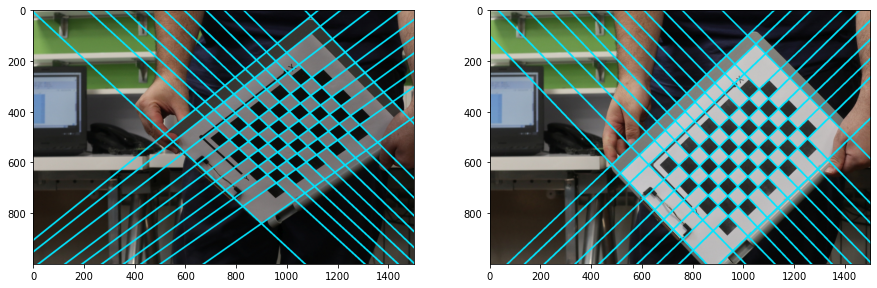

In [28]:
res1, res2 = draw_lines(img1, theta_ro_idx_arr1), draw_lines(img2, theta_ro_idx_arr2)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(cv2.cvtColor(res1, cv2.COLOR_BGR2RGB))
axs[1].imshow(cv2.cvtColor(res2, cv2.COLOR_BGR2RGB));

## Calculating intersections

We use the below formulas for calculating intersections

<img src='report_images/Intersection.png'>
<br>
<div style='background: white;'>
<img src='report_images/intersect_eq_1.svg'>
<br><br><br><br>
<img src='report_images/intersect_eq_2.svg'>
<br>
<img src='report_images/intersect_eq_3.svg'>
</div>


In [33]:
def get_intersect(p1, p2, p3, p4): # Line 1: p1->p2  -  Line 2: p3->p4
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    x4, y4 = p4
    
    D = (x1-x2)*(y3-y4) - (y1-y2)*(x3-x4)
    
    if D == 0:
        return None
        
    intersect_x = ((x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4))/D
    intersect_y = ((x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4))/D
    
    return intersect_x, intersect_y

Testing it...

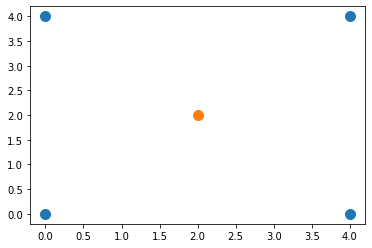

In [34]:
test_X = [0, 4, 0, 4]
test_Y = [0, 4, 4, 0]
plt.scatter(test_X, test_Y, s=100)
test_intersect = get_intersect(*zip(test_X, test_Y))
plt.scatter(test_intersect[0], test_intersect[1], s=100);

This functions draws intersection points

In [35]:
def draw_intersections(img, theta_ro_idx_arr):
    res = img.copy()
    for theta_idx1, ro_idx1 in theta_ro_idx_arr:
        for theta_idx2, ro_idx2 in theta_ro_idx_arr:
            if theta_idx1 == theta_idx2 and ro_idx1 == ro_idx2:
                continue
            x1, y1, x2, y2 = generate_two_points_from_line(theta_idx1, ro_idx1)
            x3, y3, x4, y4 = generate_two_points_from_line(theta_idx2, ro_idx2)
            intersect = get_intersect((x1, y1), (x2, y2), (x3, y3), (x4, y4))
            if intersect:
                x, y = intersect
                cv2.circle(res, (int(x), int(y)), 5, (3, 255, 118), thickness=15)
        
    return res

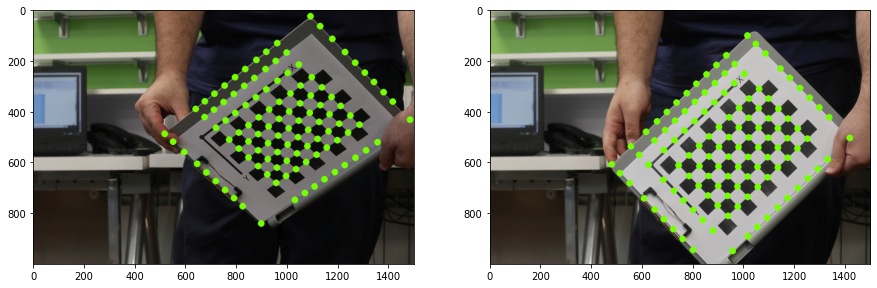

In [36]:
res1, res2 = draw_intersections(img1, theta_ro_idx_arr1), draw_intersections(img2, theta_ro_idx_arr2)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(cv2.cvtColor(res1, cv2.COLOR_BGR2RGB))
axs[1].imshow(cv2.cvtColor(res2, cv2.COLOR_BGR2RGB));